**Übung Mustererkennung** *WS 2022/23* -- *K. Brandenbusch,  Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
___
# Aufgabe 1: Nächste-Nachbar-Klassifikatoren (NN)
Zu Beginn werden auf einem Beispieldatensatz Klassifikatoren implementiert. Der `data2d` Datensatz enthält die zwei-dimensionalen Trainingsmerkmale der drei Musterklassen. Für diese Daten soll in den folgenden Aufgaben eine Klassifikation über Nächster-Nachbar und Bayesklassifikatoren realisiert werden.

**Achtung:** Gestalten Sie Ihre Implementierung so, dass die Klassifikatoren für zukünftige Aufgaben wiederverwendet werden können.

Zuerst muss das Notebook konfiguriert werden.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Uebergeordneten Ordner zum Pfad hinzufuegen, damit das common Package importiert werden kann
import sys
if '..' not in sys.path:
    sys.path.append('..')

Im Folgenden soll das Vorgehen eins $k$-Nächste-Nachbarn-Klassifikators (kNN) schrittweise implementiert werden.
Laden Sie dazu zunächst den Beispieldatensatz über die Klasse `DataProvider` (siehe [`common/data_provider.py`](../common/data_provider.py)) und visualisieren Sie die Daten anschließend.

Nützliche Funktionen: [plt.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html)

Tipp: Zu einer besseren Visualisierung sollten samples in scatter plots mit einem schwarzen Rand gezeichnet werden. Verwenden Sie dazu das Argument `edgecolor=(0, 0, 0)` oder `edgecolor='k'`.

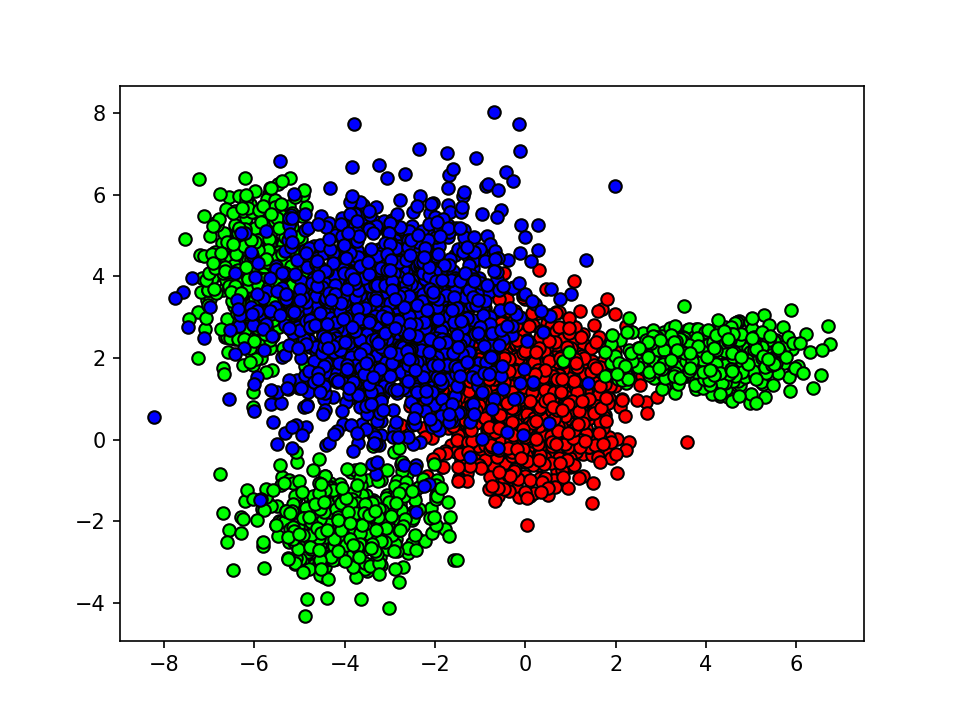

In [2]:
from common.data_provider import DataProvider
import matplotlib.pyplot as plt

train_data_provider = DataProvider(DataProvider.DATA2DROOT_TRAIN)
test_data_provider = DataProvider(DataProvider.DATA2DROOT_TEST)

_, ax = plt.subplots(dpi=150)

data = train_data_provider.get_class_arr(0)
ax.scatter(data[:, 0], data[:, 1], c='#FF0000', edgecolor='k')
data = train_data_provider.get_class_arr(1)
ax.scatter(data[:, 0], data[:, 1], c='#00FF00', edgecolor='k')
data = train_data_provider.get_class_arr(2)
ax.scatter(data[:, 0], data[:, 1], c='#0000FF', edgecolor='k')

Bevor ein Klassifikator für die Klassifikation verwendet werden kann, muss er zunächst trainiert werden.
Der Begriff des Trainings ist beim $k$-NN etwas irreführend, da keine Modelparameter im eigentlichen Sinne statistisch geschätzt werden.
Diskutieren Sie, was den $k$-NN stattdessen definiert.

In [3]:
train_samples, train_labels = train_data_provider.get_dataset_and_labels()
test_samples, test_labels_gt = test_data_provider.get_dataset_and_labels()

Ein Nächster-Nachbar-Klassifikator bestimmt das Label für ein Testsample indem es das Label des nächsten Nachbarn in den Trainingsdaten "kopiert".
Berechnen Sie daher nun die paarweisen Distanzen zwischen den Test- und Trainingsdaten.  
Verwenden Sie als Metrik eine $p$-Norm $\large ||x||_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}$. Z. B.:  
- 1-Norm: Cityblock-Metrik $\large ||x||_1 = \sum_{i=1}^n |x_i|$
- 2-Norm: Euklidischer Abstand  $\large ||x||_2 = \sqrt{\sum_{i=1}^n |x_i|^2}$
- und $\infty$-Norm: Maximumnorm $\large ||x||_\infty = \max_{i=1,\dots,n} |x_i|$ 


Nützliche Funktionen:
- [scipy.spatial.distance.cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

In [4]:
import scipy 
distancesBetweenTrainAndTest = scipy.spatial.distance.cdist(test_samples, train_samples, metric='euclidean')
print(distancesBetweenTrainAndTest.shape)

(1998, 4002)


Bestimmen Sie nun mit Hilfe der berechneten Distanzen die nächsten Nachbarn und weisen sie entsprechend den Testsamples ein Label zu.

Implementieren Sie die Entscheidung für ein Label zunächst anhand des unmittelbaren nächsten Nachbarn.
Erweitern Sie anschließend Ihre Lösung, sodass mehrere ($k$) nächste Nachbarn für die Klassifikation berücksichtigt werden.

Wie entscheidet sich der Klassifikator für ein Label, wenn die nächsten Nachbarn unterschiedliche Labels besitzen?

In [5]:
import numpy as np
from collections import Counter

calc_test_labels = np.zeros(len(distancesBetweenTrainAndTest),dtype=np.str_)
k = 6

def most_commen(array):
    #return max(set(array), key=array.count)
    data = Counter(array)
    #print(data)
    return data.most_common(1)[0][0]
  
for i in range(distancesBetweenTrainAndTest.shape[0]):
    if k<1:
        print("Error") 
    elif k==1:
        nearestNeigbor = distancesBetweenTrainAndTest[i].argmin()
        calc_test_labels[i] = train_labels[nearestNeigbor]
    else: 
        nearestNeighbors = np.argsort(distancesBetweenTrainAndTest[i])[:k]
        nearestNeighbors_labels = train_labels[nearestNeighbors]
        calc_test_labels[i] = most_commen(nearestNeighbors_labels)
    
print(sum(calc_test_labels=='2'))

596


---
## Implementierung des Klassifikators

Mit den von Ihnen umgesetzten Schritten können Sie nun die Klasse `KNNClassifier` im Modul [`common.classification`](../common/classification.py) implementieren.
Übertragen Sie Ihre Lösungen an die entsprechenden Stellen in der Klasse um den Klassifikator für zukünftige Aufgaben wiederverwenden zu können.

Zur Kontrolle können Sie ihre Ergebnisse aus den beiden Umsetzungen vergleichen.

In [6]:
from common.classification import KNNClassifier

knnClassi = KNNClassifier(6,'euclidean')
knnClassi.estimate(train_samples,train_labels)
calc_test_labels_class = knnClassi.classify(test_samples)

print(sum(calc_test_labels_class=='2'))


596


---
## Evaluation
Bei der Evaluation eines Klassifikators wird quantitativ geprüft wie _korrekt_ ein Klassifikator arbeitet.
Die Klasse `ClassificationEvaluator` im Modul [`common.classification`](../common/classification.py) implementiert ein simples Gerüst für die Evaluation der von uns implementierten Klassifikatoren.
Machen Sie sich mit der Klasse vertraut, da Sie diese auch für zukünftige Aufgaben wiederverwenden werden.

Nutzen Sie den `ClassificationEvaluator` um die Fehlerrate für Ihren `KNNClassifier` zu bestimmen.

In [7]:
from common.classification import ClassificationEvaluator

knnEvali = ClassificationEvaluator(calc_test_labels_class, test_labels_gt)
knnEvali.print_results()


Fehlerrate: 9.0; Anzahl falsch-klassifizierte Muster: 179; Anzahl Muster: 1998
Klassenspezifische Fehlerraten
Klasse 0:	Fehlerrate: 5.6;	Anzahl falsch-klassifizierte Muster:  37;	Anzahl Muster: 666
Klasse 1:	Fehlerrate: 4.2;	Anzahl falsch-klassifizierte Muster:  28;	Anzahl Muster: 666
Klasse 2:	Fehlerrate: 17.1;	Anzahl falsch-klassifizierte Muster: 114;	Anzahl Muster: 666


### Kreuzvalidierung

Den Parameter $k$ bestimmen Sie aktuell per Hand ("Expertenwissen"). Eine Möglichkeit diesen Parameter automatisiert zu bestimmen ist, den Klassifikator iterativ für mehrere $k$ auszuführen und das $k$ zu behalten welches die niedrigste Fehlerrate liefert.

Welches Problem könnte dabei entstehen?


Trainingsparameter sollten immer per Kreuzvalidierung auf den Trainingsdaten optimiert werden.
Mit den besten Parametern wird dann ein Klassifikator erstellt und auf den Testdaten evaluiert.

Bei der Kreuzvalidierung werden die Trainingsdaten in $n$ gleich grosse Teilmengen geteilt. In $n$ Durchläufen
wird dabei jeweils eine Teilmenge für die Validierung und die jeweils verbleibenden Teilmengen
zum Training verwendet. Die Ergebnisse der Kreuzvalidierung ergeben sich durch Mittelung über die Durchläufe. Die Testdaten bleiben davon unabhängig.


![Kreuzvalidierung mit Test](./xyval-test.jpg)


Welche Parameter von Klassifikatoren lassen sich mit einer Kreuzvalidierung optimieren?
Vergleichen Sie in diesem Kontext die Parameter des $k$-NN Klassifikators mit den Parametern des [Normalverteilungsklassifikators](./aufg02.ipynb).

Nutzen Sie die Klasse `CrossValidation` im Modul [`common.classification`](../common/classification.py) um den Parameter $k$ zu optimieren.
In den folgenden Aufgaben ist es Ihnen freigestellt, ob Sie Kreuzvalidierung nutzen oder direkt auf den Testdaten optimieren.

In [8]:
from common.classification import CrossValidation
knn_crossi = CrossValidation(train_samples,train_labels,5)

for i in range(1,21):
    knn_classiX = KNNClassifier(i,"euclidean")
    print(knn_crossi.validate(knn_classiX))



(10.469765117441279, [('0', 10.194902548725636), ('1', 7.04647676161919), ('2', 14.16791604197901)])
(10.469765117441279, [('0', 10.194902548725636), ('1', 7.04647676161919), ('2', 14.16791604197901)])
(8.895552223888055, [('0', 8.020989505247375), ('1', 4.7976011994003), ('2', 13.868065967016493)])
(8.770614692653673, [('0', 7.571214392803598), ('1', 5.097451274362818), ('2', 13.643178410794603)])
(8.370814592703647, [('0', 6.896551724137931), ('1', 3.5232383808095955), ('2', 14.692653673163417)])
(8.320839580209896, [('0', 7.121439280359819), ('1', 3.2983508245877062), ('2', 14.54272863568216)])
(8.045977011494251, [('0', 6.596701649175413), ('1', 3.5982008995502244), ('2', 13.94302848575712)])
(8.045977011494253, [('0', 6.746626686656672), ('1', 3.1484257871064467), ('2', 14.242878560719639)])
(7.7211394302848575, [('0', 6.221889055472264), ('1', 2.9985007496251868), ('2', 13.94302848575712)])
(7.77111444277861, [('0', 6.221889055472264), ('1', 3.073463268365817), ('2', 14.017991004

---
## Optional
Führen Sie qualitative Evaluation durch. Plotten sie dazu die Ergebnisse unter Verwendung verschiedener Metriken in [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html).
